In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
from sklearn import metrics
from copy import deepcopy
#from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
import csv
from time import perf_counter
import csv
import torch.nn as nn
import torch_geometric.nn as gnn
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
from torch.nn.modules import activation
from time import perf_counter
import random
import pandas
import statistics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Explainability_name = 'CAM'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
Model_name = "DGCNN"
DataSet_name = "MUTAG"
normalize_coeff = 1
File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [ ]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [ ]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [ ]:
torch.manual_seed(123456)
#dataset = dataset.shuffle()

#train_dataset = dataset[:150]
#test_dataset = dataset[150:]
train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


# **Batching Data by DataLoader**

In [ ]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64
size_of_hidden_layers = 7

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# **Model Designing**

In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import GCN_plus_GAP as Graph_Network
GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2,
                                       num_hid_layers=2, Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1,
                                       dropout_rate=classifier_dropout)
#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun='ReLu', dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=20, node_feat_size=7, hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])


GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
eLu is Selected.
GCN_plus_GAP(
  (GConvs): ModuleList(
    (0-1): 2 x GCNConv(7, 7)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=True)
)
GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
ReLu is Selected.


In [ ]:
GNN_Model_optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch


In [ ]:
def loading_model(load_index):
    GNN_Model = Graph_Network.GCN_plus_GAP(hidden_channels=size_of_hidden_layers)
    GNN_Model_optimizer = torch.optim.Adam(params = GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)
    checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")
    GNN_Model.load_state_dict(checkpoint['model_state_dict'])
    GNN_Model_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']


    return GNN_Model, GNN_Model_optimizer, epoch

In [ ]:
def visualize_losses(cam_losses, epoch_history):
    cam_losses_list = torch.stack(cam_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("CAM Model Loss in Epoch: " + str(epoch_history))

    ax.plot(cam_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()




# **Traning Configurations**

In [ ]:
def train_step():
    CAM_loss_batch = []
    CAM_Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model_optimizer.zero_grad()
    for batched_data in train_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        pred = soft.argmax(dim=1)

        CAM_Pred_Labels.extend(pred.detach().tolist())
        Real_Labels.extend(batched_data.y.detach().tolist())

        CAM_loss = loss_calculations(soft, batched_data.y)
        CAM_loss_batch.append(CAM_loss)
        CAM_loss.backward()
        GNN_Model_optimizer.step()


    return torch.mean(torch.tensor(CAM_loss_batch)), metrics.accuracy_score(Real_Labels, CAM_Pred_Labels)


In [ ]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [ ]:
CAM_Model_training_time_per_epoch = []
CAM_Model_training_Acc_per_epoch = []
def train(EPOCHS, load_index):
    CAM_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        start_generation = perf_counter()
        CAM_model_training_loss, training_acc = train_step()
        CAM_Model_training_time_per_epoch.append(perf_counter() - start_generation)
        CAM_Model_training_Acc_per_epoch.append(training_acc)
        print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {CAM_model_training_loss:.4f}')

        CAM_training_loss_per_epoch.append(CAM_model_training_loss)
        #break

        if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
            visualize_losses(CAM_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_optimizer.state_dict(), 'loss': CAM_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")


    #return model_loss





Epoch: 001, CAM Model Loss: 0.6995
Epoch: 002, CAM Model Loss: 0.6978
Epoch: 003, CAM Model Loss: 0.6970
Epoch: 004, CAM Model Loss: 0.6954
Epoch: 005, CAM Model Loss: 0.6943
Epoch: 006, CAM Model Loss: 0.6931
Epoch: 007, CAM Model Loss: 0.6919
Epoch: 008, CAM Model Loss: 0.6906
Epoch: 009, CAM Model Loss: 0.6881
Epoch: 010, CAM Model Loss: 0.6876
Epoch: 011, CAM Model Loss: 0.6874
Epoch: 012, CAM Model Loss: 0.6875
Epoch: 013, CAM Model Loss: 0.6871
Epoch: 014, CAM Model Loss: 0.6856
Epoch: 015, CAM Model Loss: 0.6834
Epoch: 016, CAM Model Loss: 0.6871
Epoch: 017, CAM Model Loss: 0.6816
Epoch: 018, CAM Model Loss: 0.6819
Epoch: 019, CAM Model Loss: 0.6816
Epoch: 020, CAM Model Loss: 0.6802
Epoch: 021, CAM Model Loss: 0.6793
Epoch: 022, CAM Model Loss: 0.6778
Epoch: 023, CAM Model Loss: 0.6769
Epoch: 024, CAM Model Loss: 0.6775
Epoch: 025, CAM Model Loss: 0.6770
Epoch: 026, CAM Model Loss: 0.6731
Epoch: 027, CAM Model Loss: 0.6711
Epoch: 028, CAM Model Loss: 0.6625
Epoch: 029, CAM Mode

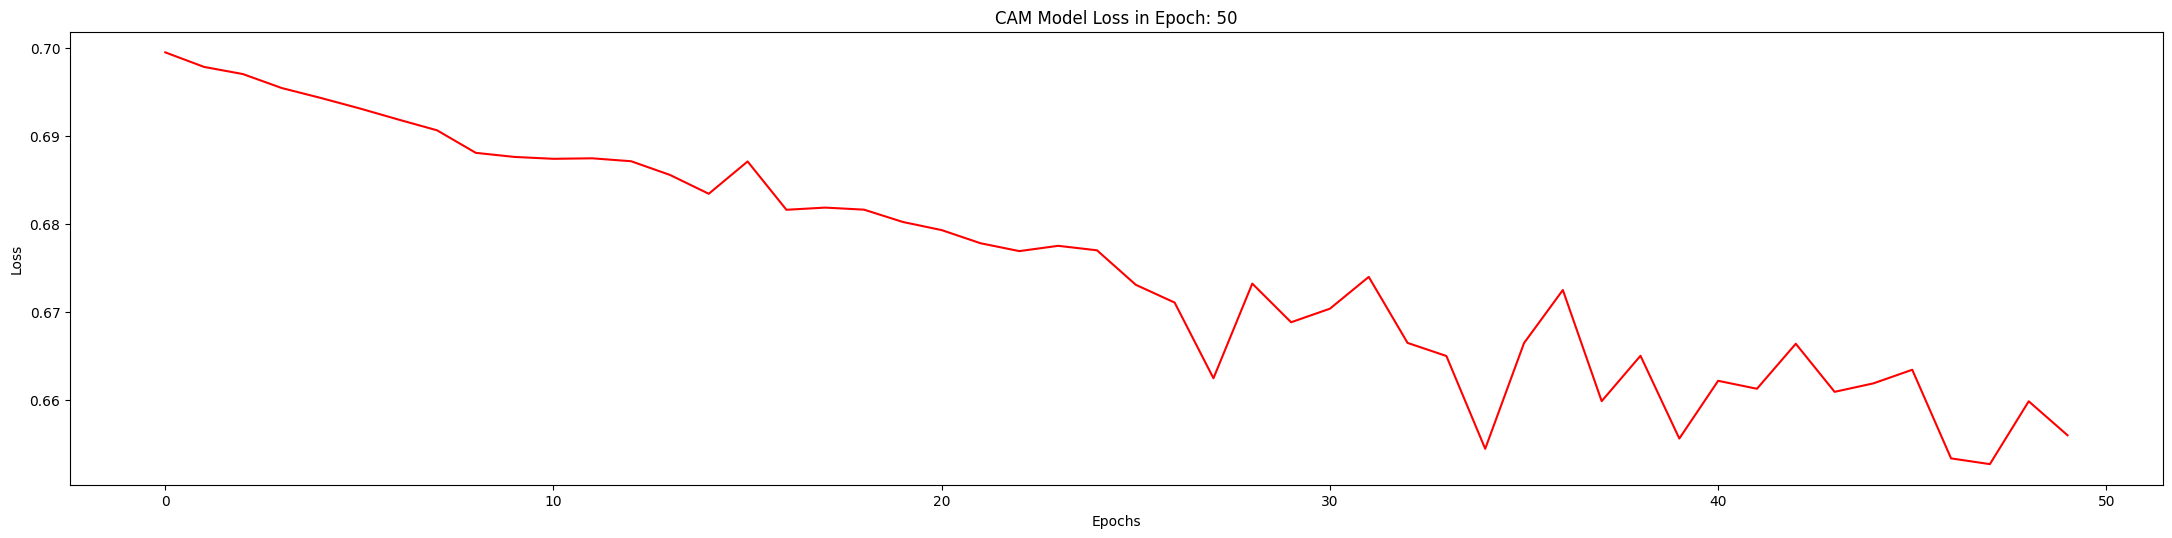

Epoch: 051, CAM Model Loss: 0.6651
Epoch: 052, CAM Model Loss: 0.6603
Epoch: 053, CAM Model Loss: 0.6522
Epoch: 054, CAM Model Loss: 0.6350
Epoch: 055, CAM Model Loss: 0.6551
Epoch: 056, CAM Model Loss: 0.6504
Epoch: 057, CAM Model Loss: 0.6607
Epoch: 058, CAM Model Loss: 0.6430
Epoch: 059, CAM Model Loss: 0.6448
Epoch: 060, CAM Model Loss: 0.6531
Epoch: 061, CAM Model Loss: 0.6375
Epoch: 062, CAM Model Loss: 0.6495
Epoch: 063, CAM Model Loss: 0.6425
Epoch: 064, CAM Model Loss: 0.6552
Epoch: 065, CAM Model Loss: 0.6337
Epoch: 066, CAM Model Loss: 0.6294
Epoch: 067, CAM Model Loss: 0.6400
Epoch: 068, CAM Model Loss: 0.6396
Epoch: 069, CAM Model Loss: 0.6395
Epoch: 070, CAM Model Loss: 0.6264
Epoch: 071, CAM Model Loss: 0.6459
Epoch: 072, CAM Model Loss: 0.6465
Epoch: 073, CAM Model Loss: 0.6442
Epoch: 074, CAM Model Loss: 0.6364
Epoch: 075, CAM Model Loss: 0.6363
Epoch: 076, CAM Model Loss: 0.6311
Epoch: 077, CAM Model Loss: 0.6210
Epoch: 078, CAM Model Loss: 0.6353
Epoch: 079, CAM Mode

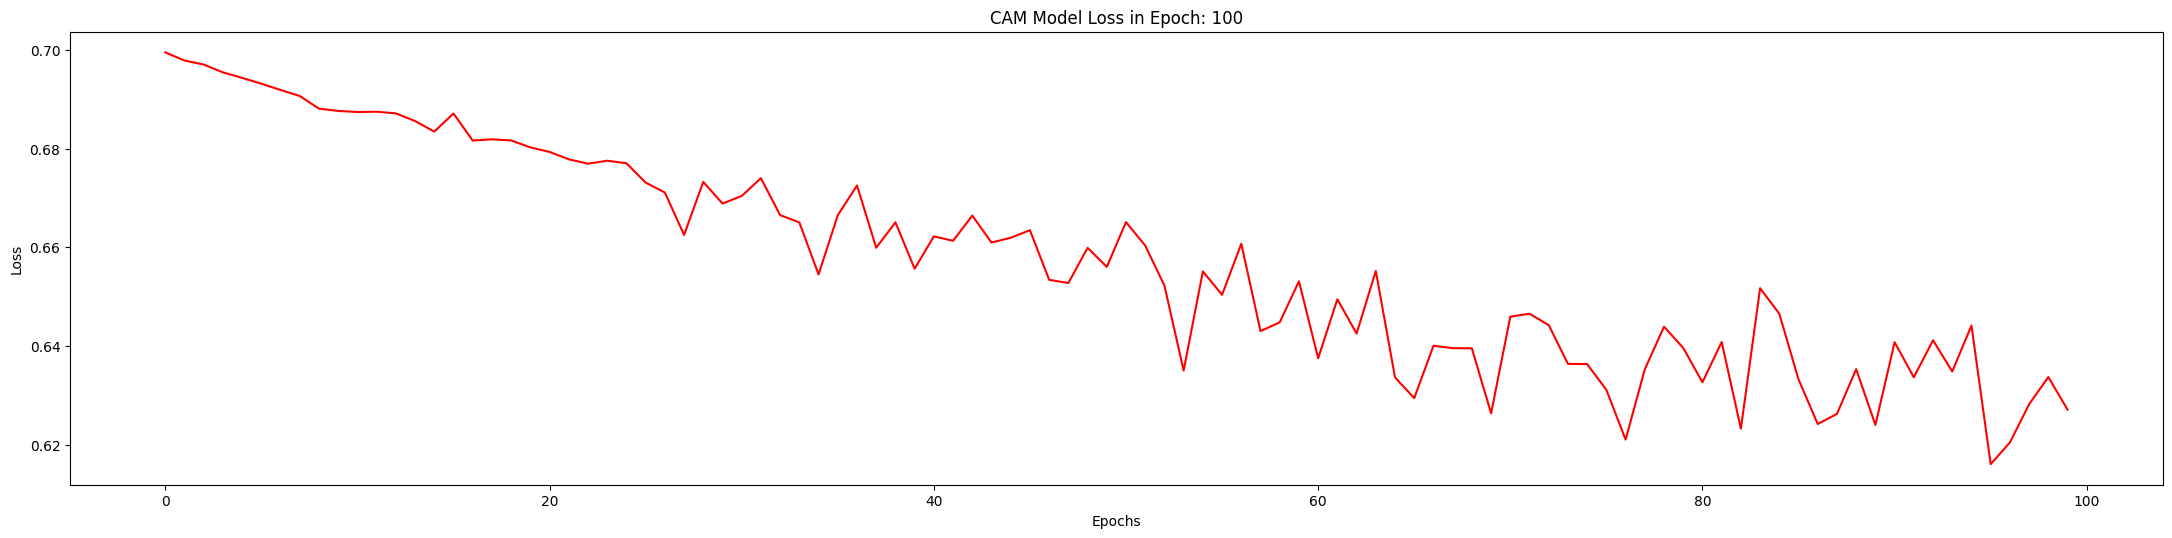

Epoch: 101, CAM Model Loss: 0.6092
Epoch: 102, CAM Model Loss: 0.6308
Epoch: 103, CAM Model Loss: 0.6400
Epoch: 104, CAM Model Loss: 0.6378
Epoch: 105, CAM Model Loss: 0.6271
Epoch: 106, CAM Model Loss: 0.6264
Epoch: 107, CAM Model Loss: 0.6361
Epoch: 108, CAM Model Loss: 0.6079
Epoch: 109, CAM Model Loss: 0.6316
Epoch: 110, CAM Model Loss: 0.6245
Epoch: 111, CAM Model Loss: 0.6247
Epoch: 112, CAM Model Loss: 0.6372
Epoch: 113, CAM Model Loss: 0.6062
Epoch: 114, CAM Model Loss: 0.6366
Epoch: 115, CAM Model Loss: 0.6413
Epoch: 116, CAM Model Loss: 0.5988
Epoch: 117, CAM Model Loss: 0.6282
Epoch: 118, CAM Model Loss: 0.6175
Epoch: 119, CAM Model Loss: 0.6231
Epoch: 120, CAM Model Loss: 0.6288
Epoch: 121, CAM Model Loss: 0.6233
Epoch: 122, CAM Model Loss: 0.6062
Epoch: 123, CAM Model Loss: 0.6398
Epoch: 124, CAM Model Loss: 0.6349
Epoch: 125, CAM Model Loss: 0.6043
Epoch: 126, CAM Model Loss: 0.6048
Epoch: 127, CAM Model Loss: 0.6137
Epoch: 128, CAM Model Loss: 0.6339
Epoch: 129, CAM Mode

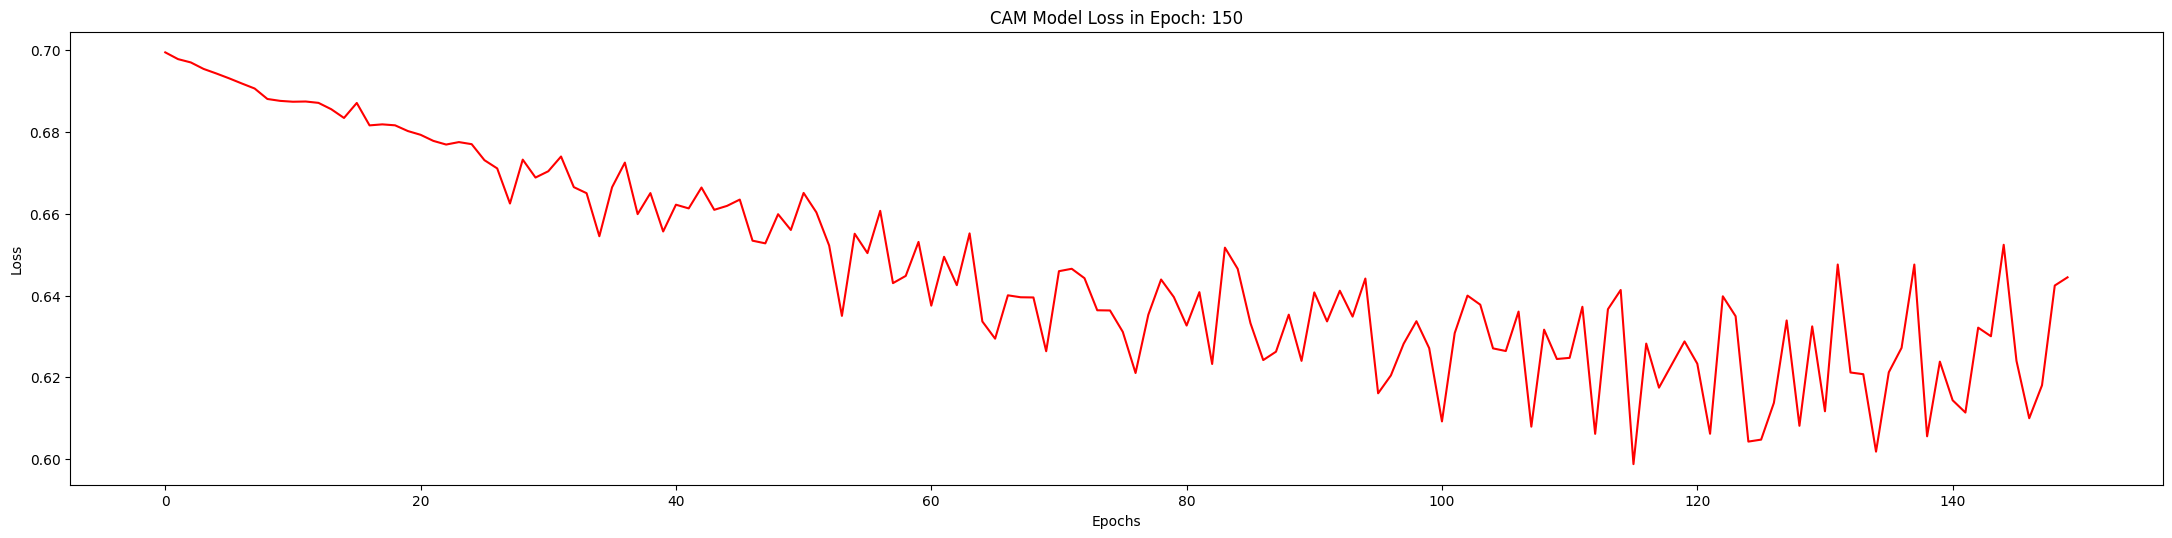

Epoch: 151, CAM Model Loss: 0.6189
Epoch: 152, CAM Model Loss: 0.6075
Epoch: 153, CAM Model Loss: 0.6025
Epoch: 154, CAM Model Loss: 0.6097
Epoch: 155, CAM Model Loss: 0.5991
Epoch: 156, CAM Model Loss: 0.6287
Epoch: 157, CAM Model Loss: 0.6026
Epoch: 158, CAM Model Loss: 0.6377
Epoch: 159, CAM Model Loss: 0.6058
Epoch: 160, CAM Model Loss: 0.6198
Epoch: 161, CAM Model Loss: 0.6262
Epoch: 162, CAM Model Loss: 0.6199
Epoch: 163, CAM Model Loss: 0.6018
Epoch: 164, CAM Model Loss: 0.6090
Epoch: 165, CAM Model Loss: 0.6108
Epoch: 166, CAM Model Loss: 0.6164
Epoch: 167, CAM Model Loss: 0.5922
Epoch: 168, CAM Model Loss: 0.6220
Epoch: 169, CAM Model Loss: 0.6060
Epoch: 170, CAM Model Loss: 0.6249
Epoch: 171, CAM Model Loss: 0.6105
Epoch: 172, CAM Model Loss: 0.6223
Epoch: 173, CAM Model Loss: 0.6149
Epoch: 174, CAM Model Loss: 0.6229
Epoch: 175, CAM Model Loss: 0.6072
Epoch: 176, CAM Model Loss: 0.6095
Epoch: 177, CAM Model Loss: 0.6410
Epoch: 178, CAM Model Loss: 0.6144
Epoch: 179, CAM Mode

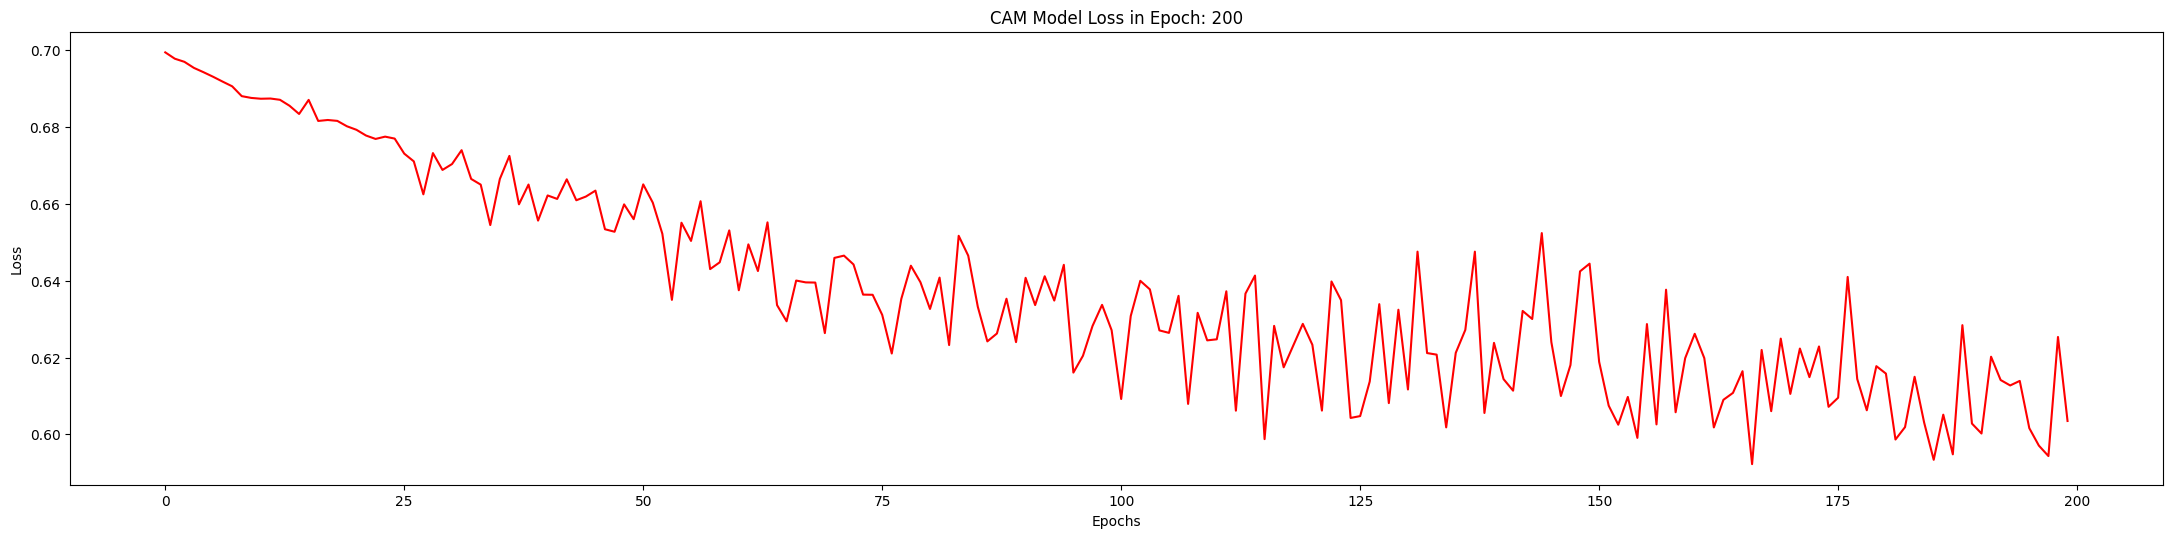

Epoch: 201, CAM Model Loss: 0.6080
Epoch: 202, CAM Model Loss: 0.5880
Epoch: 203, CAM Model Loss: 0.6174
Epoch: 204, CAM Model Loss: 0.5984
Epoch: 205, CAM Model Loss: 0.6065
Epoch: 206, CAM Model Loss: 0.6015
Epoch: 207, CAM Model Loss: 0.6136
Epoch: 208, CAM Model Loss: 0.5995
Epoch: 209, CAM Model Loss: 0.6182
Epoch: 210, CAM Model Loss: 0.6210
Epoch: 211, CAM Model Loss: 0.6169
Epoch: 212, CAM Model Loss: 0.5933
Epoch: 213, CAM Model Loss: 0.5833
Epoch: 214, CAM Model Loss: 0.6266
Epoch: 215, CAM Model Loss: 0.5895
Epoch: 216, CAM Model Loss: 0.6169
Epoch: 217, CAM Model Loss: 0.6204
Epoch: 218, CAM Model Loss: 0.5954
Epoch: 219, CAM Model Loss: 0.6042
Epoch: 220, CAM Model Loss: 0.5947
Epoch: 221, CAM Model Loss: 0.6129
Epoch: 222, CAM Model Loss: 0.6066
Epoch: 223, CAM Model Loss: 0.5993
Epoch: 224, CAM Model Loss: 0.6087
Epoch: 225, CAM Model Loss: 0.5852
Epoch: 226, CAM Model Loss: 0.5873
Epoch: 227, CAM Model Loss: 0.6210
Epoch: 228, CAM Model Loss: 0.6084
Epoch: 229, CAM Mode

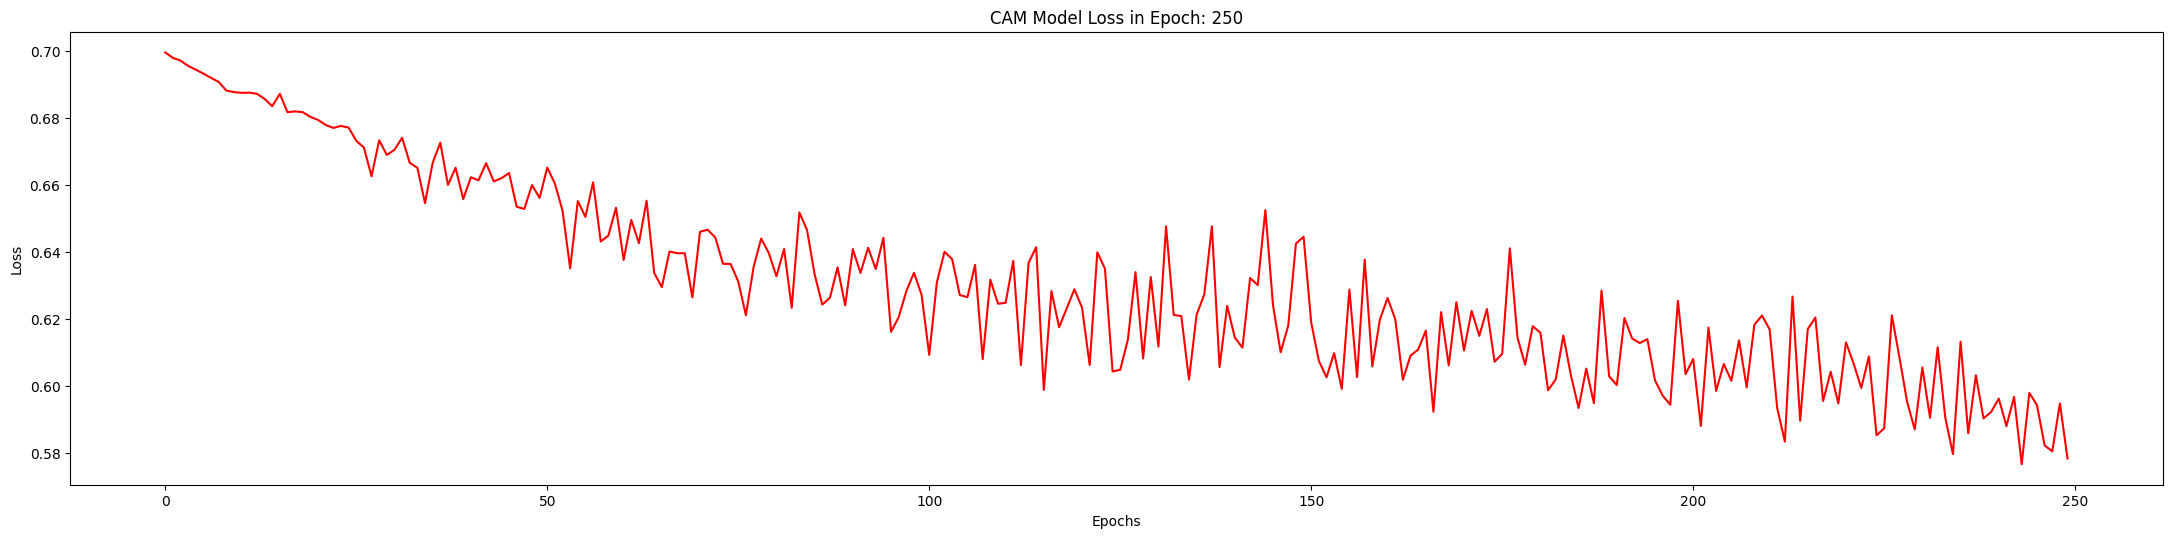

Epoch: 251, CAM Model Loss: 0.5902
Epoch: 252, CAM Model Loss: 0.5895
Epoch: 253, CAM Model Loss: 0.6060
Epoch: 254, CAM Model Loss: 0.5844
Epoch: 255, CAM Model Loss: 0.5906
Epoch: 256, CAM Model Loss: 0.5792
Epoch: 257, CAM Model Loss: 0.5852
Epoch: 258, CAM Model Loss: 0.5739
Epoch: 259, CAM Model Loss: 0.6034
Epoch: 260, CAM Model Loss: 0.5825
Epoch: 261, CAM Model Loss: 0.5971
Epoch: 262, CAM Model Loss: 0.5801
Epoch: 263, CAM Model Loss: 0.5944
Epoch: 264, CAM Model Loss: 0.5838
Epoch: 265, CAM Model Loss: 0.5945
Epoch: 266, CAM Model Loss: 0.5598
Epoch: 267, CAM Model Loss: 0.6042
Epoch: 268, CAM Model Loss: 0.5959
Epoch: 269, CAM Model Loss: 0.6042
Epoch: 270, CAM Model Loss: 0.5985
Epoch: 271, CAM Model Loss: 0.6024
Epoch: 272, CAM Model Loss: 0.6078
Epoch: 273, CAM Model Loss: 0.5755
Epoch: 274, CAM Model Loss: 0.5617
Epoch: 275, CAM Model Loss: 0.5886
Epoch: 276, CAM Model Loss: 0.5928
Epoch: 277, CAM Model Loss: 0.5825
Epoch: 278, CAM Model Loss: 0.5917
Epoch: 279, CAM Mode

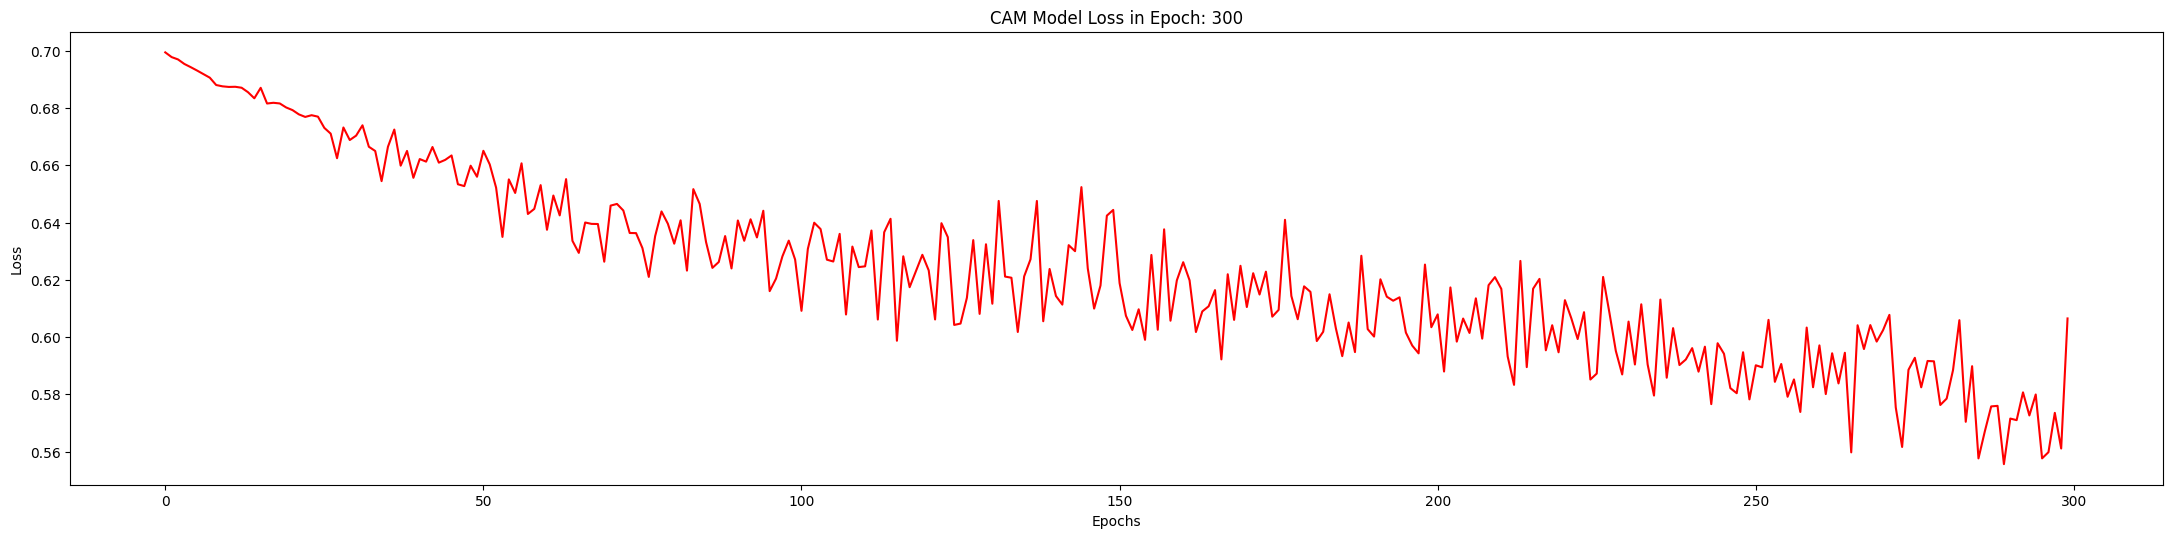

In [ ]:
EPOCHS = 300
load_index = 0
if load_index != 0:
    model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [ ]:
def GNN_Model_test(test_loader):
    predictions = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        CAM_test_pred = soft.argmax(dim=1)
        predictions.append(CAM_test_pred.detach().tolist()[0])
        #print(CAM_test_pred)
        correct += int((CAM_test_pred == batched_data.y).sum())
    return correct / len(test_loader.dataset), predictions

In [ ]:
CAM_test_acc, predictions = GNN_Model_test(test_loader)
print(f'Test Accuracy: {CAM_test_acc:.4f}')

Test Accuracy: 0.5789


In [ ]:
print(predictions)
real_labels = []
for graph in test_dataset:
    real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [ ]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print(Auc_Roc, Auc_Prc, Acc, Acc2)

0.5178571428571428 0.775375939849624 0.5789473684210527 22


## **Instance Specific Time**

In [ ]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        CAM_test_pred = soft.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [ ]:
times = instance_time(test_dataset)
print(f'Test Instance based Time: {times}')

Test Instance based Time: [0.002973202000021047, 0.0022387369999705697, 0.0018291940000381146, 0.0017566220000162502, 0.002104192000047078, 0.003255638000041472, 0.003912044000003334, 0.0018720000000485015, 0.001612195999996402, 0.0016404830000738002, 0.0016478249999636319, 0.001741044000027614, 0.0016619480001054399, 0.001751749999925778, 0.0016459620001114672, 0.001698416000067482, 0.001750599999922997, 0.001683686000092166, 0.001597860999936529, 0.0016485370000509647, 0.0016392989999758356, 0.0015958760000103211, 0.0016670679999606364, 0.0017424999999775537, 0.0019416970000065703, 0.0018966480000699448, 0.002155313000002934, 0.0017637460000514693, 0.0018360610000627275, 0.001796046999970713, 0.0016736839999111908, 0.0032820970000102534, 0.001720719999980247, 0.0017400069999666812, 0.0020040069999822663, 0.0018301319998954568, 0.0018052739999347978, 0.0017647260000330789]


# **CAM Function**

In [ ]:
import cv2
def return_CAM(feature_conv, weight, class_idx):
    # generate the class -activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

# **Weights of The Trained Model old way**

In [ ]:
parameters_of_the_Model = list(GNN_Model.parameters())
weights_last_layer = np.squeeze(parameters_of_the_Model[-2].data.numpy())

In [ ]:
print(weights_last_layer)

[[-0.47978026 -0.7252333   0.9826429  -0.3930818  -0.74208057 -0.10097596
   0.03460425]
 [ 0.8630811   0.5300224  -0.33967084 -0.90210223  0.7998524   0.98685795
   1.2013918 ]]


In [ ]:

StateDict = GNN_Model.state_dict()
print(StateDict.keys())
whole_weights = StateDict.items()
print(whole_weights)


GConv1_biases = StateDict.get('GConvs.0.bias')
GConv1_Weights = StateDict.get('GConvs.0.lin.weight')

GConv2_biases = StateDict.get('GConvs.1.bias')
GConv2_Weights = StateDict.get('GConvs.1.lin.weight')

#Conv3_biases = StateDict.get('conv3.bias')
#Conv3_Weights = StateDict.get('conv3.lin.weight')

Dense_biases = StateDict.get('ffn.bias')
Dense_Weights = StateDict.get('ffn.weight')

print(f'Length of CONV1_Weights: {len(GConv1_Weights)}')
print(f'Length of CONV1.Bias: {len(GConv1_biases)}')

print(f'Length of CONV2_Weights: {len(GConv2_Weights)}')
print(f'Length of CONV2.Bias: {len(GConv2_biases)}')

#print(f'Length of CONV3_Weights: {len(Conv3_Weights)}')
#print(f'Length of CONV3.Bias: {len(Conv3_biases)}')

print(f'Length of Dense_Weights: {len(Dense_Weights)}')
print(f'Length of Dense.Bias: {len(Dense_biases)}')


odict_keys(['GConvs.0.bias', 'GConvs.0.lin.weight', 'GConvs.1.bias', 'GConvs.1.lin.weight', 'ffn.weight', 'ffn.bias'])
odict_items([('GConvs.0.bias', tensor([ 0.1505,  0.1513, -0.1820,  0.0252,  0.0378,  0.6861,  0.1250])), ('GConvs.0.lin.weight', tensor([[ 0.5448,  0.1976, -0.7129,  0.8056,  0.2361,  0.5207,  0.8119],
        [ 0.1132, -0.1334, -2.1021, -2.1757,  0.9783, -0.5774, -0.9650],
        [ 0.6953, -0.9953, -1.6230, -1.6379,  1.1546, -1.4397, -0.3621],
        [-0.0492,  0.6183, -1.2314,  0.3615, -0.3984,  0.3977,  1.2377],
        [-0.2404,  0.8057, -0.1373,  1.3486, -0.7343,  0.8697,  0.6411],
        [-0.6860,  0.5581,  2.3574,  2.2962, -1.3726,  1.4990,  1.0594],
        [-0.6115,  0.9411, -1.2757,  1.9437, -0.6731,  0.5481,  1.2363]])), ('GConvs.1.bias', tensor([ 0.0797, -0.2183,  0.2893, -0.2095, -0.0927,  0.2142,  0.2905])), ('GConvs.1.lin.weight', tensor([[ 0.8230,  1.7453,  1.9672,  0.2919, -1.3527, -1.8493, -0.5467],
        [-0.1875,  0.6093,  1.0685,  0.1921, -1.0

In [ ]:
print(Dense_Weights)

tensor([[-1.1136, -1.2036,  1.3932, -0.2872, -1.4295, -0.0542, -0.0047],
        [ 1.3900,  0.8197, -0.3324, -1.3285,  1.3032,  1.2323,  1.5067]])


In [ ]:
x = GNN_Model.GConvs[0].lin.weight.data
y = GNN_Model.GConvs[1].lin.weight.data
print(x)
print(y)

tensor([[ 0.5448,  0.1976, -0.7129,  0.8056,  0.2361,  0.5207,  0.8119],
        [ 0.1132, -0.1334, -2.1021, -2.1757,  0.9783, -0.5774, -0.9650],
        [ 0.6953, -0.9953, -1.6230, -1.6379,  1.1546, -1.4397, -0.3621],
        [-0.0492,  0.6183, -1.2314,  0.3615, -0.3984,  0.3977,  1.2377],
        [-0.2404,  0.8057, -0.1373,  1.3486, -0.7343,  0.8697,  0.6411],
        [-0.6860,  0.5581,  2.3574,  2.2962, -1.3726,  1.4990,  1.0594],
        [-0.6115,  0.9411, -1.2757,  1.9437, -0.6731,  0.5481,  1.2363]])
tensor([[ 0.8230,  1.7453,  1.9672,  0.2919, -1.3527, -1.8493, -0.5467],
        [-0.1875,  0.6093,  1.0685,  0.1921, -1.0932, -1.4701, -0.1856],
        [ 1.7293, -0.0192,  0.2822,  1.2334,  0.1027,  0.1063,  0.2068],
        [ 0.4820,  0.7613, -0.8059,  1.0598,  0.5745, -0.4237,  0.7714],
        [-0.0559,  1.4296,  1.3374,  0.5944, -1.1274, -1.7666, -0.6923],
        [-0.5809,  0.1379,  0.4338, -0.3113, -0.6052,  0.6559, -0.5594],
        [-0.6912, -0.0700,  0.1008, -1.0093, -0.16

## **Weights of the Model**

In [ ]:
def weights_of_model(model):
    Dense_Layer_Weights = model.ffn.weight
    #Dense_Layer_Biases = model.lin.bias.data

    #GConv3_Layer_Weights = model.conv3.lin.weight.data
    GConv2_Layer_Weights = model.GConvs[1].lin.weight.data
    GConv1_Layer_Weights = model.GConvs[0].lin.weight.data

    Dense_Layer_Weights = Dense_Layer_Weights.detach().tolist()
    #GConv3_Layer_Weights = GConv3_Layer_Weights.detach().tolist()
    GConv2_Layer_Weights = GConv2_Layer_Weights.detach().tolist()
    GConv1_Layer_Weights = GConv1_Layer_Weights.detach().tolist()

    #return GConv1_Layer_Weights, GConv2_Layer_Weights, GConv3_Layer_Weights, Dense_Layer_Weights
    return GConv1_Layer_Weights, GConv2_Layer_Weights, Dense_Layer_Weights

In [ ]:
GConv1_Layer_Weights, GConv2_Layer_Weights, Dense_Layer_Weights = weights_of_model(GNN_Model)

In [ ]:
print(np.shape(GConv1_Layer_Weights))
print(np.shape(GConv2_Layer_Weights))
#print(np.shape(GConv3_Layer_Weights))
print(np.shape(Dense_Layer_Weights))

(7, 7)
(7, 7)
(2, 7)


# **Feature MAPs**

In [ ]:
def CAM_FeatureMAP_production(test_loader):
    index_of_winner_labels = []
    FeatureMaps_of_the_Last_Conv = []
    output_of_the_GAP = []
    Final_predictions = []

    GNN_Model.eval()
    for batched_data in test_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        #index_of_winner_label = CAM_output.argmax(dim=1)
        #logits = F.log_softmax(CAM_output, dim=1)
        #prob = F.softmax(logits, dim=1)
        index_of_winner_label = soft.argmax(dim=1)

        index_of_winner_labels.append(index_of_winner_label.detach().tolist())
        Final_predictions.append(soft.detach().tolist())
        output_of_the_GAP.append(pooling_layer_output.detach().tolist())
        FeatureMaps_of_the_Last_Conv.append(Output_of_Hidden_Layers[1].detach().tolist())
    return FeatureMaps_of_the_Last_Conv, output_of_the_GAP, Final_predictions, index_of_winner_labels

In [ ]:
FeatureMaps_of_the_Last_Conv, output_of_the_GAP, Final_predictions, index_of_winner_labels = CAM_FeatureMAP_production(test_dataset)

In [ ]:
#FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv.detach().numpy()
#output_of_the_GAP = torch.stack(output_of_the_GAP).cpu().detach().numpy()
#Final_predictions = torch.stack(Final_predictions).cpu().detach().numpy()
#Dense_Weights = Dense_Weights.detach().numpy()
#Dense_Weights = Dense_Weights.tolist()
#index_list = index_list.detach().numpy()
#index_of_winner_labels = index_of_winner_labels.tolist()
#FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv.tolist()


In [ ]:
#print(FeatureMaps_of_the_Last_Conv)
print(len(FeatureMaps_of_the_Last_Conv[0]))
print(np.shape(FeatureMaps_of_the_Last_Conv))
print(np.shape(output_of_the_GAP))
print(np.shape(Final_predictions))
print(Final_predictions)
print(index_of_winner_labels)

17
(38,)
(38, 1, 7)
(38, 1, 2)
[[[0.018096502870321274, 0.9819035530090332]], [[0.1767546832561493, 0.8232453465461731]], [[0.1796370893716812, 0.82036292552948]], [[0.7267718315124512, 0.2732281982898712]], [[0.031336456537246704, 0.9686635732650757]], [[0.057797130197286606, 0.9422028064727783]], [[0.05333305895328522, 0.946666955947876]], [[0.02776125818490982, 0.9722387194633484]], [[0.01804807409644127, 0.981951892375946]], [[0.02350549027323723, 0.9764944911003113]], [[0.6308044791221619, 0.36919549107551575]], [[0.3602718114852905, 0.6397281289100647]], [[0.6393437385559082, 0.3606562316417694]], [[0.020464520901441574, 0.9795355200767517]], [[0.010958372615277767, 0.9890416264533997]], [[0.5483846664428711, 0.4516153335571289]], [[0.020760273560881615, 0.9792397022247314]], [[0.15846680104732513, 0.8415331840515137]], [[0.0726470798254013, 0.9273529052734375]], [[0.01083549577742815, 0.9891645312309265]], [[0.18761181831359863, 0.8123881816864014]], [[0.06288496404886246, 0.937

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
#FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv[0].copy()

# **Weights W.R.T...**

In [ ]:
def weight_wrt_class_and_performance(index_of_winner_labels, GNN_Model):
    GConv1_Layer_Weights, GConv2_Layer_Weights, Dense_Layer_Weights = weights_of_model(GNN_Model)
    Weights_of_the_Predicted_Class = []
    for i in range(len(index_of_winner_labels)):
        Weights_of_the_Predicted_Class.append(Dense_Layer_Weights[index_of_winner_labels[i][0]])

    Weights_of_the_Class_0 = []
    for i in range(len(index_of_winner_labels)):
        Weights_of_the_Class_0.append(Dense_Layer_Weights[0])

    Weights_of_the_Class_1 = []
    for i in range(len(index_of_winner_labels)):
        Weights_of_the_Class_1.append(Dense_Layer_Weights[1])

    return Weights_of_the_Predicted_Class, Weights_of_the_Class_0, Weights_of_the_Class_1

In [ ]:
Weights_of_the_Predicted_Class, Weights_of_the_Class_0, Weights_of_the_Class_1 = weight_wrt_class_and_performance(index_of_winner_labels, GNN_Model)

In [ ]:
print(np.shape(Weights_of_the_Predicted_Class))
print(np.shape(Weights_of_the_Class_0))
print(np.shape(Weights_of_the_Class_1))

(38, 7)
(38, 7)
(38, 7)


In [ ]:
print(Weights_of_the_Class_0)
print(Weights_of_the_Class_1)

[[-0.47978025674819946, -0.7252333164215088, 0.9826428890228271, -0.39308181405067444, -0.742080569267273, -0.10097596049308777, 0.03460425138473511], [-0.47978025674819946, -0.7252333164215088, 0.9826428890228271, -0.39308181405067444, -0.742080569267273, -0.10097596049308777, 0.03460425138473511], [-0.47978025674819946, -0.7252333164215088, 0.9826428890228271, -0.39308181405067444, -0.742080569267273, -0.10097596049308777, 0.03460425138473511], [-0.47978025674819946, -0.7252333164215088, 0.9826428890228271, -0.39308181405067444, -0.742080569267273, -0.10097596049308777, 0.03460425138473511], [-0.47978025674819946, -0.7252333164215088, 0.9826428890228271, -0.39308181405067444, -0.742080569267273, -0.10097596049308777, 0.03460425138473511], [-0.47978025674819946, -0.7252333164215088, 0.9826428890228271, -0.39308181405067444, -0.742080569267273, -0.10097596049308777, 0.03460425138473511], [-0.47978025674819946, -0.7252333164215088, 0.9826428890228271, -0.39308181405067444, -0.7420805692

In [ ]:
print(np.shape(Weights_of_the_Predicted_Class))
print(np.shape(FeatureMaps_of_the_Last_Conv))

(38, 7)
(38,)


In [ ]:
#Feature_Maps_of_the_Last_Conv = []
#for i in range(len(test_dataset)):
#  Feature_Maps_of_the_Last_Conv.append(FeatureMaps_of_the_Last_Conv[0:test_dataset[i].num_nodes])
#  FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv[test_dataset[i].num_nodes:]

In [ ]:
print(len(FeatureMaps_of_the_Last_Conv))
print(len(FeatureMaps_of_the_Last_Conv[0]))
print(len(FeatureMaps_of_the_Last_Conv[0][0]))
print(len(test_dataset))

#for i in range(len(test_dataset)):
#  print(test_dataset[i].num_nodes, len(Feature_Maps_of_the_Last_Conv[i]))

38
17
7
38


# **Attribution of Weights and Maps**

In [ ]:
from numpy import exp
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

In [ ]:
def CAM_Attribution_Scores(weights, feat_maps):
    Weights_and_Maps_Multiplication_on_Nodes_of_each_graph = []
    Normalized_Attributions = []

    for i in range(len(feat_maps)):
        Each_Graph = []
        for j in range(len(feat_maps[i])):
            Each_Graph.append(np.sum(np.multiply(weights[i], feat_maps[i][j])))
        Weights_and_Maps_Multiplication_on_Nodes_of_each_graph.append(Each_Graph)

    #for Each_Graph in Weights_and_Maps_Multiplication_on_Nodes_of_each_graph:
    #    each_g = []
    #    for each_node in Each_Graph:
    #        norm = [(float(i) - min(each_node)) * normalize_coeff / (max(each_node) - min(each_node)) for i in each_node]
    #        each_g.append(norm)
    #    Normalized_Attributions.append(each_g)
    #Standardize_Attributions_final = []
    #for graph in Normalized_Attributions:
    #    Standardize_Attributions_final.append([node/max(graph) for node in graph])
    return Weights_and_Maps_Multiplication_on_Nodes_of_each_graph

In [ ]:
start_time = perf_counter()
FeatureMaps_of_the_Last_Conv, output_of_the_GAP, Final_predictions, index_of_winner_labels = CAM_FeatureMAP_production(test_dataset)
Weights_of_the_Predicted_Class, Weights_of_the_Class_0, Weights_of_the_Class_1 = weight_wrt_class_and_performance(index_of_winner_labels, GNN_Model)

atts_gpred = CAM_Attribution_Scores(Weights_of_the_Predicted_Class, FeatureMaps_of_the_Last_Conv)
atts_class0 = CAM_Attribution_Scores(Weights_of_the_Class_0, FeatureMaps_of_the_Last_Conv)
atts_class1 = CAM_Attribution_Scores(Weights_of_the_Class_1, FeatureMaps_of_the_Last_Conv)

consumed_time = perf_counter() - start_time
print("consumed_time: ", consumed_time/(3*len(test_dataset)))

consumed_time:  0.0006007892631571035


In [ ]:
print((atts_class0))

[[0.04730843894332448, 0.04730843894332448, 0.03822888510925093, 0.07698194376105061, 0.0792594815440486, 0.04306618781915095, 0.03661643320664698, 0.03661643320664698, 0.07367380347853558, 0.07698194376105061, 0.031779130496746966, -0.07643819711281896, -0.24382298177034656, -0.0806803915238623, -0.9384191012319008, -0.7912378755691805, -0.7912378755691805], [0.04085872414589442, 0.04306624453228114, -0.033795142020431435, 0.04306624453228114, -0.126750498537068, -0.3008094553467857, -0.47241443627891755, -0.28472031399420406, -0.35775872923166285, -0.07482574673009879, -0.9412374141964079, -0.7912378755691805, -0.7912378755691805], [0.04085872414589442, -0.08747799790952637, -0.18453466171204003, -0.13398084848223402, 0.03822888510925093, -0.126750498537068, -0.3008094553467857, -0.469160174149323, -0.24470408285449885, -0.07482574673009879, -0.9412374141964079, -0.7912378755691805, -0.7912378755691805], [-0.07643819711281896, -0.09392775927701624, -0.2934000500186198, -0.60944557255

In [ ]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
eval_xai_fid_plus = reload(eval_xai_fid_plus)

In [ ]:
fid_xmethod_example_2 = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                               test_data=test_dataset)
fid_score2 = fid_xmethod_example_2.my_fidelity(saliency_class0=atts_class0, saliency_class1=atts_class1, importance_threshold=0.01,
                                               style="Node")
print(fid_score2)

0.10416666666666674


In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
eval_xai_contrastivity = reload(eval_xai_contrastivity)

In [ ]:
contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                     test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, atts_class0,
                                                                     atts_class1, importance_threshold=0.5,
                                                                     contrast_coeff=1e+14)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.5256911266252858


In [ ]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_sparsity as eval_xai_sparsity
eval_xai_sparsity = reload(eval_xai_sparsity)

In [ ]:
print(len(atts_class0[0]))

17


In [ ]:
sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                     test_data=test_dataset)
sparsity_score = sparsity_xmethod_example.my_sparsity(test_dataset, atts_class0,
                                                                     atts_class1, importance_threshold=0.7)
print("Sparsity_Score: ", sparsity_score)

Sparsity_Score:  0.4927299261773336


## **Fidelity**

In [ ]:
def Compute_ROC_AUC(your_model, your_dataset):
    preds = []
    reals = []


    your_model.eval()
    for batched_data in your_dataset:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)


        preds.append(soft.cpu().detach())

    for i in range(len(your_dataset)):
        reals.append(your_dataset[i].y.cpu().detach().tolist())
    #preds = torch.cat(preds).cpu().numpy()
    #preds = preds[:, 1]
    preds = torch.cat(preds)
    preds, max_idxs = torch.max(preds[:], dim=1)


    roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
    return roc_auc

In [ ]:
def is_salient(score, importance_threshold):
    if importance_threshold == score == 0:
        return True
    if importance_threshold == score == 1:
        return False
    if importance_threshold < score:
        return True
    else:
        return False

In [ ]:
def drop_important_nodes(your_dataset, importance_range, weights, feat_maps):
    CAM_attribution_scores = CAM_Attribution_Scores(weights, feat_maps)
    occluded_GNNgraph_list = []

    for i in range(len(CAM_attribution_scores)):
        sample_graph = deepcopy(your_dataset[i])
        for j in range(len(CAM_attribution_scores[i])):
            if is_salient(CAM_attribution_scores[i][j], importance_range):
                #print("before: ", sample_graph.x[j])
                sample_graph.x[j][:] = 0
                #print(torch.zeros_like(sample_graph.x[j]))
                #print("manipulated: ",sample_graph.x[j])
        occluded_GNNgraph_list.append(sample_graph)
    return occluded_GNNgraph_list

In [ ]:
def Fidelity(your_model, your_dataset, weights, feat_maps, importance_range):

    auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
    new_graph_dataset = drop_important_nodes(your_dataset, importance_range, weights, feat_maps)
    auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

    return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes

## **Contrastivity**

In [ ]:
def normalize_for_contrastivity(gcam_atts):
    final = []
    for graph in gcam_atts:
        temp = []
        for score in graph:
            temp.append(score*10000000000 - int(score*10000000000))
        final.append(temp)
    return final

In [ ]:
from tables import node
def binarize_scores(weights, feat_maps, importance_threshold):
    CAM_attribution_scores = CAM_Attribution_Scores(weights, feat_maps)
    CAM_attribution_scores = normalize_for_contrastivity(CAM_attribution_scores)
    binarized_attribution_scores_list = []
    for i in range(len(CAM_attribution_scores)):
        binary_score = ''
        sample_graph = deepcopy(CAM_attribution_scores[i])
        for j in range(len(sample_graph)):
            if is_salient(CAM_attribution_scores[i][j], importance_threshold):
                binary_score += '1'
            else:
                binary_score += '0'
        binarized_attribution_scores_list.append(binary_score)
    return binarized_attribution_scores_list

In [ ]:
def hamming_distance(string1, string2):

    distance = 0
    L = len(string1)
    for i in range(L):
        if string1[i] != string2[i]:
            distance += 1
    return distance

In [ ]:
def compute_contrastivity(weights_class0, weights_class1, feat_maps, importance_threshold):
    binarized_salient_nodes_for_class0 = binarize_scores(weights_class0, feat_maps, importance_threshold)
    binarized_salient_nodes_for_class1 = binarize_scores(weights_class1, feat_maps, importance_threshold)


    result_list = []
    for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):

        d = hamming_distance(class_0, class_1)/len(class_0)
        result_list.append(d)


    return mean(result_list)


In [ ]:
contrastivity_with_cam = compute_contrastivity(Weights_of_the_Class_0, Weights_of_the_Class_1, FeatureMaps_of_the_Last_Conv, 0.5)
print("contrastivity_with_cam: ", contrastivity_with_cam)

contrastivity_with_cam:  0.44018630602311376


## **Sparsity**

In [ ]:
def binarize_nodes(weights_class0, weights_class1, weights_preds, feat_maps, importance_threshold):
    CAM_attribution_scores_class0 = CAM_Attribution_Scores(weights_class0, feat_maps)
    CAM_attribution_scores_class1 = CAM_Attribution_Scores(weights_class1, feat_maps)
    CAM_attribution_scores_graph = CAM_Attribution_Scores(weights_preds, feat_maps)


    class_0_salient_nodes = []
    class_1_salient_nodes = []
    salient_nodes_preds = []

    for i in range(len(CAM_attribution_scores_class0)):
        class_0_graph = []
        for j in range(len(CAM_attribution_scores_class0[i])):
            class_0_node = []
            if is_salient((CAM_attribution_scores_class0[i][j]), importance_threshold):
                class_0_node.append(1)
            else:
                class_0_node.append(0)
            class_0_graph.append(class_0_node)
        class_0_salient_nodes.append(class_0_graph)

    for i in range(len(CAM_attribution_scores_class1)):
        class_1_graph = []
        for j in range(len(CAM_attribution_scores_class1[i])):
            class_1_node = []
            if is_salient((CAM_attribution_scores_class1[i][j]), importance_threshold):
                class_1_node.append(1)
            else:
                class_1_node.append(0)
            class_1_graph.append(class_1_node)
        class_1_salient_nodes.append(class_1_graph)

    for i in range(len(CAM_attribution_scores_graph)):
        class_graph = []
        for j in range(len(CAM_attribution_scores_graph[i])):
            class_node = []
            if is_salient(CAM_attribution_scores_graph[i][j], importance_threshold):
                class_node.append(1)
            else:
                class_node.append(0)
            class_graph.append(class_node)
        salient_nodes_preds.append(class_graph)

    return salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes

In [ ]:
def count_important_nodes(salient_list):
    #print("salient_list: ", salient_list)
    summed = 0
    for sl in salient_list:
        summed = summed + sum(sl)
    return summed

In [ ]:
def compute_sparsity(feat_maps, weights_preds, weights_class0, weights_class1, importance_range):
    salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(weights_class0, weights_class1, weights_preds, feat_maps, importance_range)
    #print(salient_nodes_graph)
    #print(class_0_salient_nodes)
    #print(class_1_salient_nodes)
    sparsity_list = []
    for i in range(len(salient_nodes_preds)):
        d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
        d = d / (len(salient_nodes_preds[i]) * 2)
        sparsity_list.append(1 - d)
    return sum(sparsity_list) / len(sparsity_list)

## **Get Metrics**

In [ ]:
def go_to_evaluations(your_model, dataset, importance_threshold):
    start_generation = perf_counter()

    GConv1_Layer_Weights, GConv2_Layer_Weights, Dense_Layer_Weights = weights_of_model(your_model)
    FeatureMaps_of_the_Last_Conv, output_of_the_GAP, Final_predictions, index_of_winner_labels = CAM_FeatureMAP_production(dataset)
    Weights_of_the_Predicted_Class, Weights_of_the_Class_0, Weights_of_the_Class_1 = weight_wrt_class_and_performance(index_of_winner_labels, Dense_Layer_Weights)
    CAM_Atts = CAM_Attribution_Scores(Weights_of_the_Predicted_Class, FeatureMaps_of_the_Last_Conv)

    time_consumption = perf_counter() - start_generation

    fid_cam_label = round(Fidelity(your_model, dataset, Weights_of_the_Predicted_Class, FeatureMaps_of_the_Last_Conv, importance_threshold), 3)
    print("fid_cam_label: ", fid_cam_label)
    contrastivity_with_cam = compute_contrastivity(Weights_of_the_Class_0, Weights_of_the_Class_1, FeatureMaps_of_the_Last_Conv, importance_threshold)
    print("contrastivity_with_cam: ", contrastivity_with_cam)
    sparsity_with_cam = compute_sparsity(FeatureMaps_of_the_Last_Conv, Weights_of_the_Predicted_Class, Weights_of_the_Class_0, Weights_of_the_Class_1, importance_threshold)
    print("sparsity_with_cam: ", sparsity_with_cam)

    #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
    #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
    #  wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    #  wr.writerow([str(Explainability_name), "MUTAG", fid_cam_label, contrastivity_with_cam, sparsity_with_cam, time_consumption])
    #task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
    #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", 'a') as outcsv:
    #    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    #    wr.writerow([str(Explainability_name), task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, CAM_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_cam_label, contrastivity_with_cam, sparsity_with_cam, time_consumption, mean(CAM_Model_training_time_per_epoch), times])

    return fid_cam_label, contrastivity_with_cam, sparsity_with_cam, time_consumption

In [ ]:
fid_cam_glabel, contrastivity_with_cam, sparsity_with_cam, time_consumption = go_to_evaluations(GNN_Model, test_dataset, 0.5)
#go_to_evaluations(GNN_Model, test_dataset, 0.25)

fid_cam_label:  0.03
contrastivity_with_cam:  0.44018630602311376
sparsity_with_cam:  0.5355788879699223


In [ ]:
time_consumption

0.05129963800004589

In [ ]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv")
print("here, ", df.loc[2, 'Explicability Method Name'])
df = df.drop(2)
#df.loc[2, 'Fidelity'] = fid_cam_glabel
#df.loc[2, 'Contrastivity'] = contrastivity_with_cam
#df.loc[2, 'Sparsity'] = sparsity_with_cam
df.to_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", index=False)


here,  CAM


In [ ]:
#print(fid_cam_glabel, contrastivity_with_cam, sparsity_with_cam, time_consumption)

# **Pointwise Average for each Graph**

In [ ]:
CAMs_AVG_for_each_Graph = []
for i in range(len(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph)):
  CAMs_AVG_for_each_Graph.append(np.mean(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph[i], axis=0))   # MEAN or ARGMAX then divide by counts of nodes in each GRAPH
print(np.shape(CAMs_AVG_for_each_Graph))

(38, 7)


# **Point-Wise Sum for each Graph**

In [ ]:
CAMs_SUM_for_each_Graph = []
for i in range(len(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph)):
  sum = [0] * len(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph[0][0])
  for j in range(len(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph[i])):
    sum = list( map(add, sum, Weights_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j]))
  CAMs_SUM_for_each_Graph.append(sum)

In [ ]:
print(np.shape(CAMs_SUM_for_each_Graph))
print(len(Weights_and_Maps_Multiplication_on_Nodes_of_each_graph[0]))
print(CAMs_AVG_for_each_Graph[0])
print(CAMs_SUM_for_each_Graph[0])

(38, 7)
28
[ 1.36272633  2.44386814  2.17782187  0.         -1.64666757  0.
  0.        ]
[38.15633737072264, 68.42830787437154, 60.97901244183305, 0.0, -46.10669198197817, 0.0, 0.0]


# **Plot Attributes of Each Graph (i.e., in SUM of its Nodes)**

In [ ]:
def visualize_CAMs(CAMs_Graphs, index, HIV_status):

  fig = plt.figure(figsize=(15,10))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Attributes')
  plt.ylabel('CAMs; Weights & Feature Maps')
  plt.title("CAMs in Test Graph: " + str(index+1) + " whith " + str(HIV_status) + "status")

  ax.plot(CAMs_Graphs, color='r')

  plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'CAMs in Test Graph {:04d} with {} status.png'.format(index+1, HIV_status))
  plt.show()

In [ ]:
HIV_POS = []
HIV_NEG = []

HIV_POS_index = []
HIV_NEG_index = []

for i, x in enumerate(CAMs_SUM_for_each_Graph):
  if index_list[i]:
    HIV_POS.append(x)
    HIV_POS_index.append(i)
  else:
    HIV_NEG.append(x)
    HIV_NEG_index.append(i)
print(len(HIV_POS))
print(len(HIV_NEG))

print(len(HIV_POS_index))
print(len(HIV_NEG_index))
print(index_list)
print(HIV_POS_index)
print(HIV_NEG_index)

27
11
27
11
[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
[0, 2, 3, 5, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 22, 23, 24, 27, 28, 29, 30, 32, 33, 34, 36, 37]
[1, 4, 6, 7, 13, 20, 21, 25, 26, 31, 35]


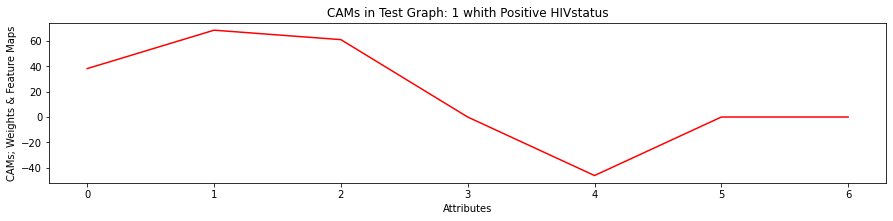

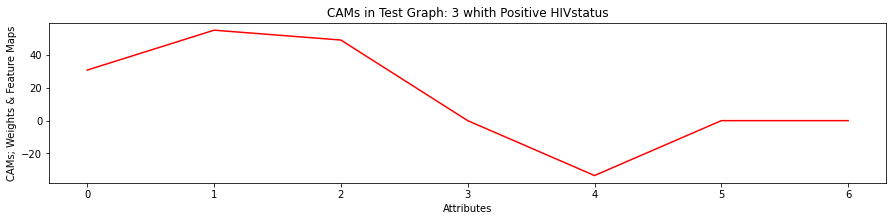

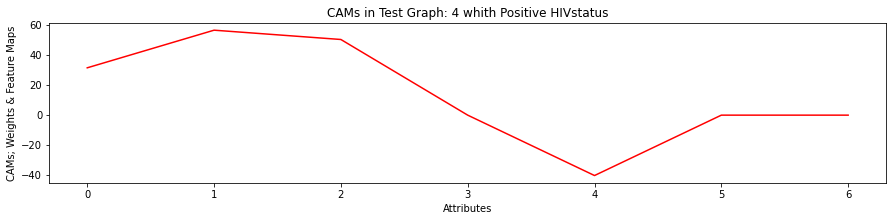

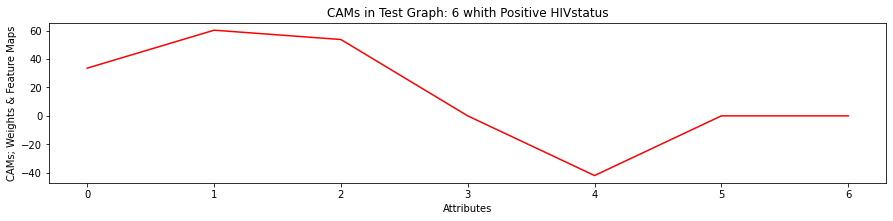

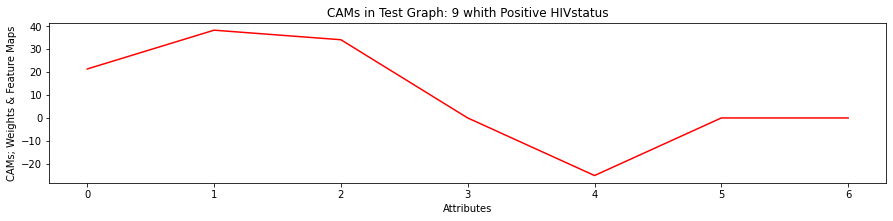

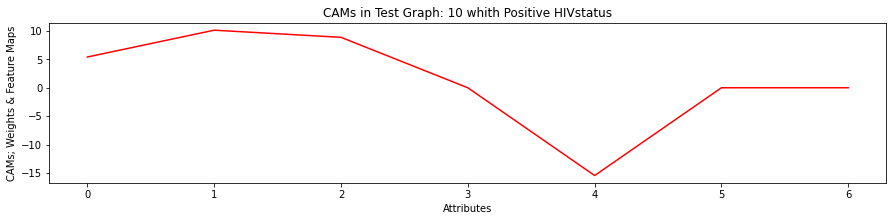

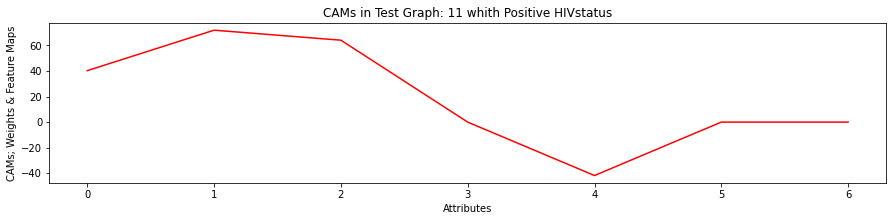

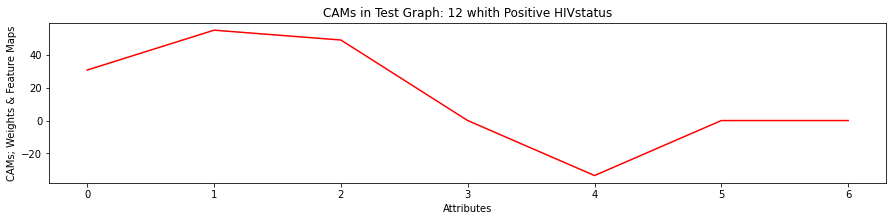

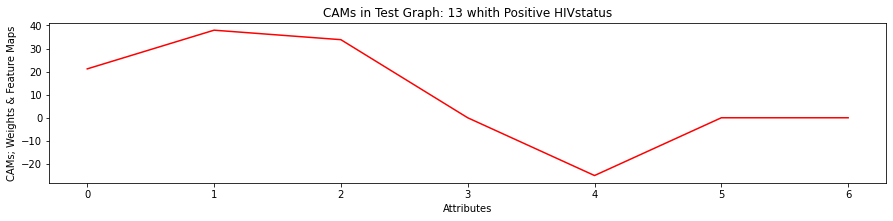

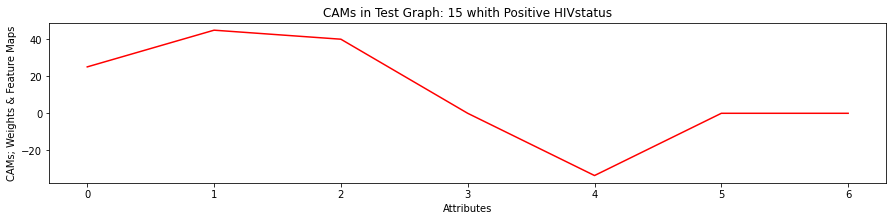

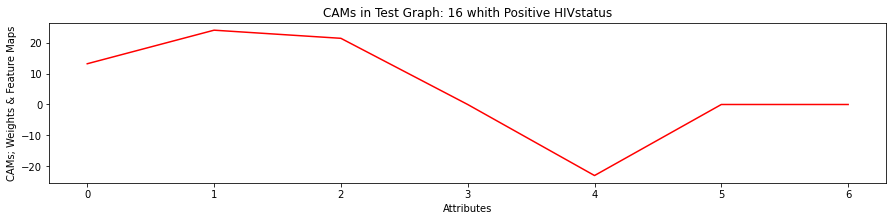

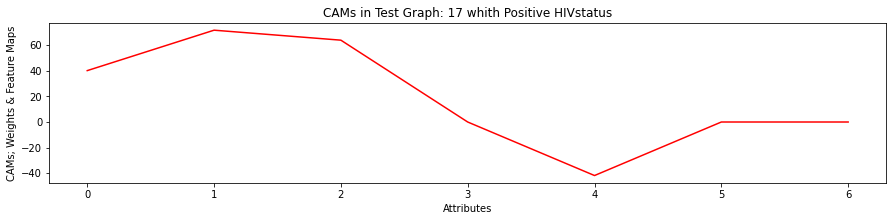

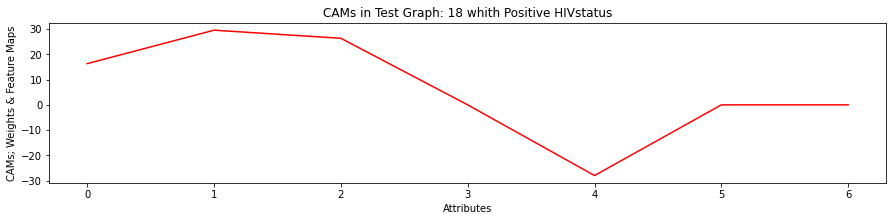

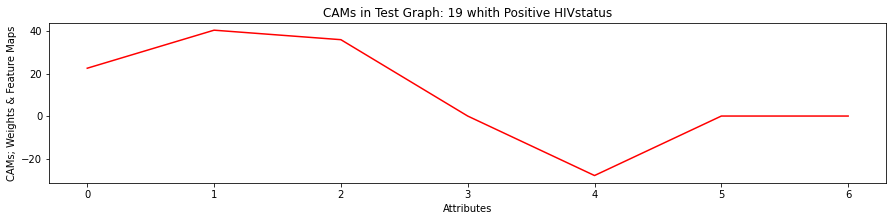

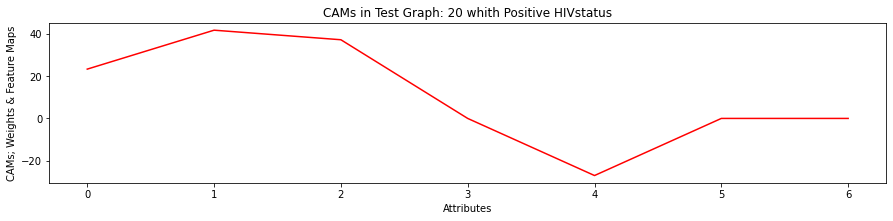

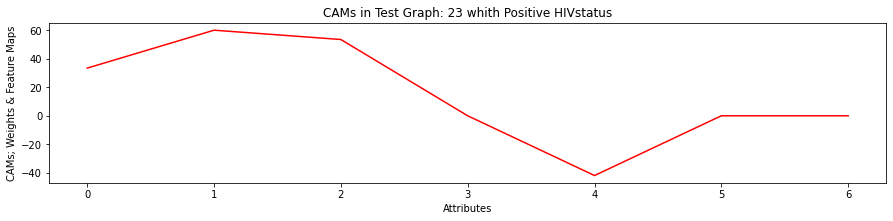

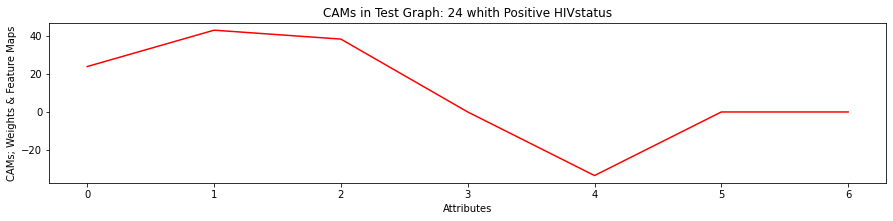

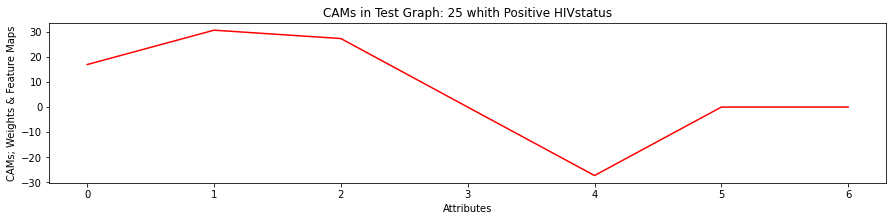

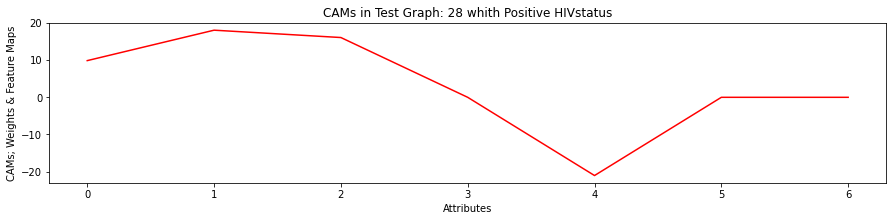

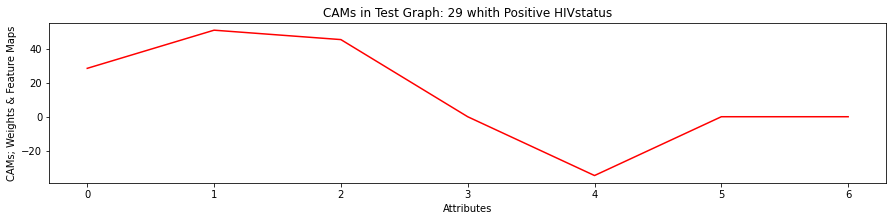

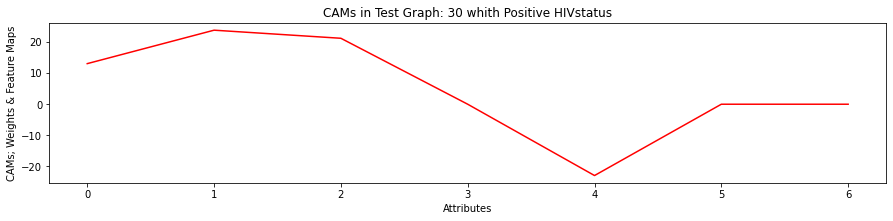

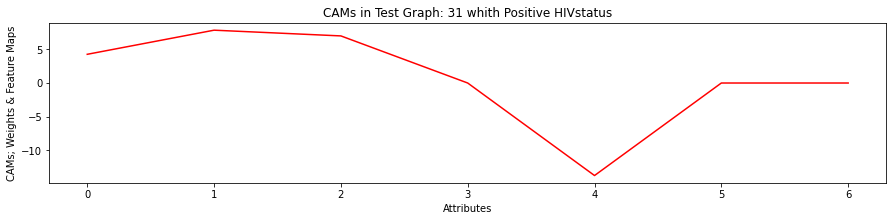

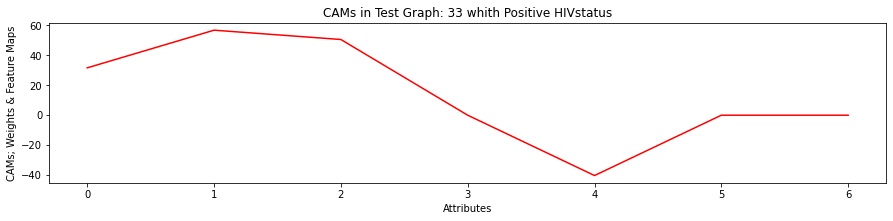

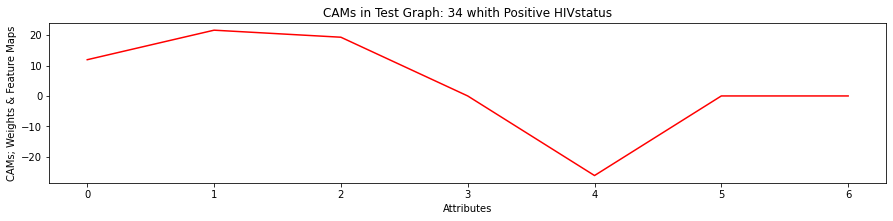

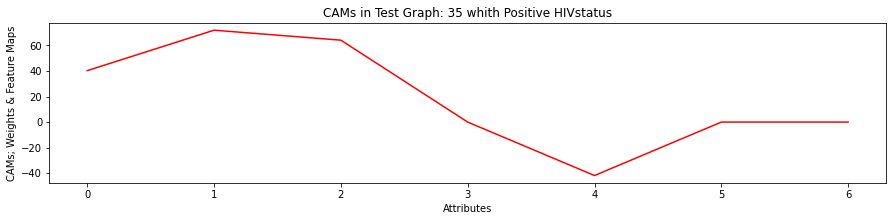

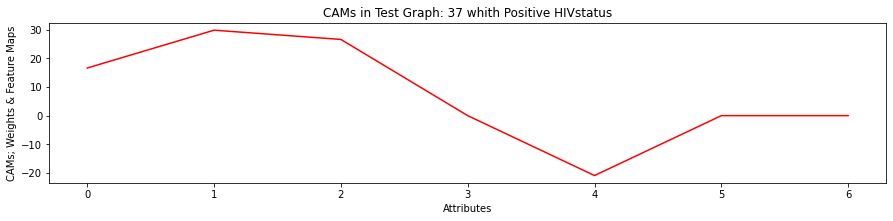

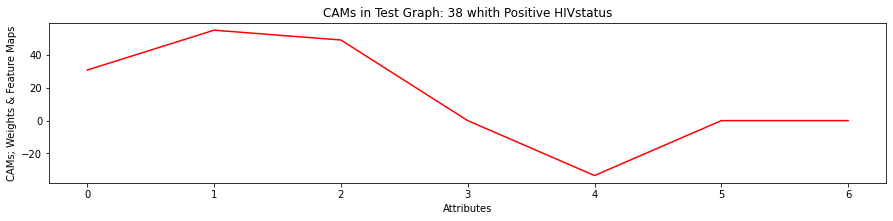

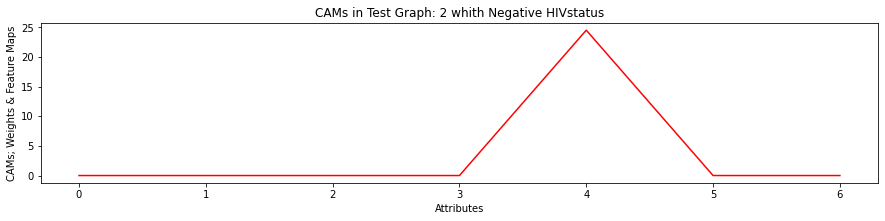

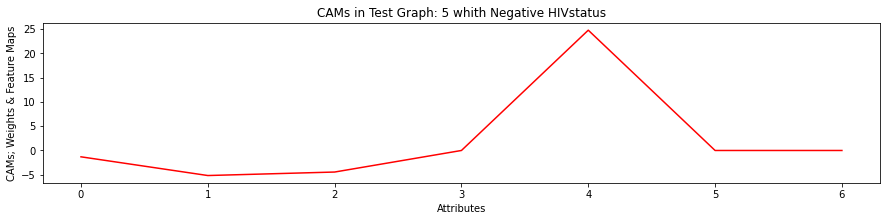

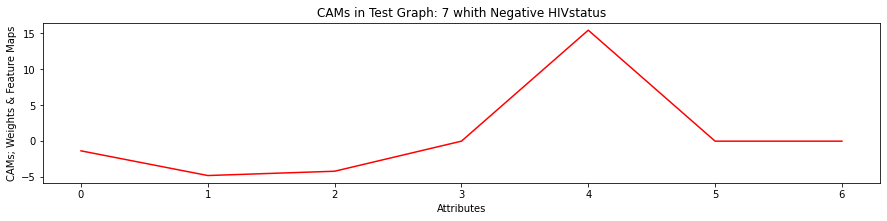

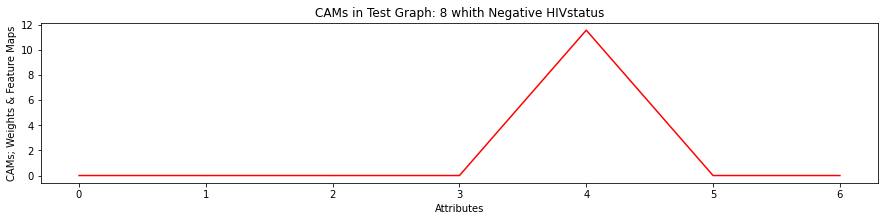

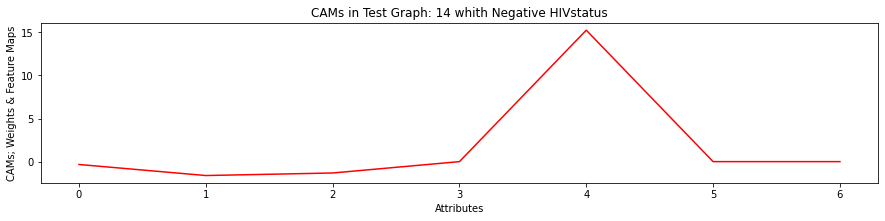

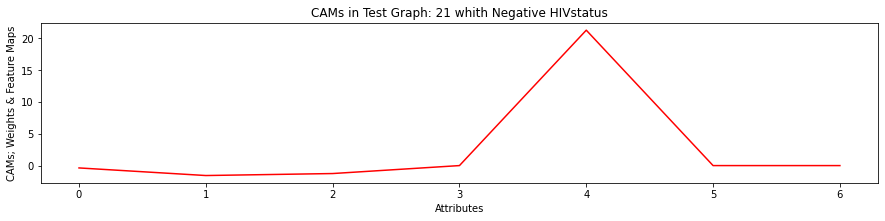

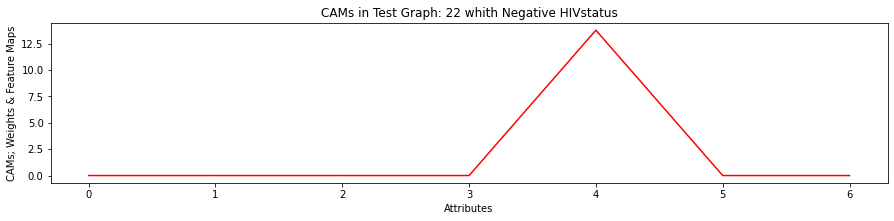

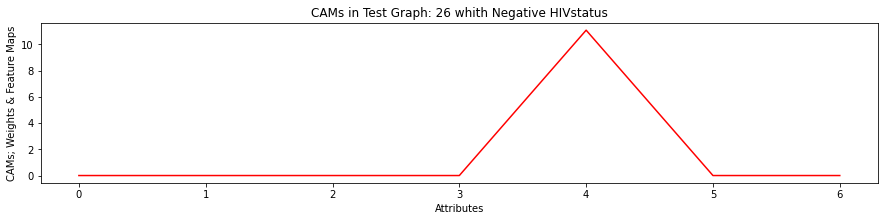

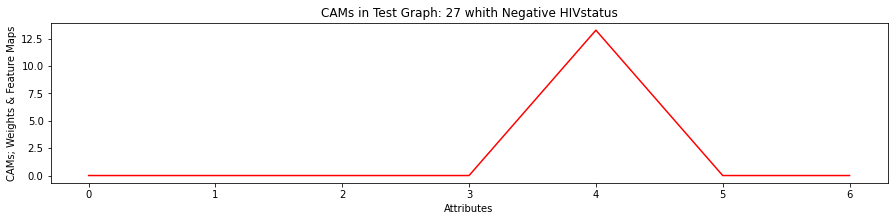

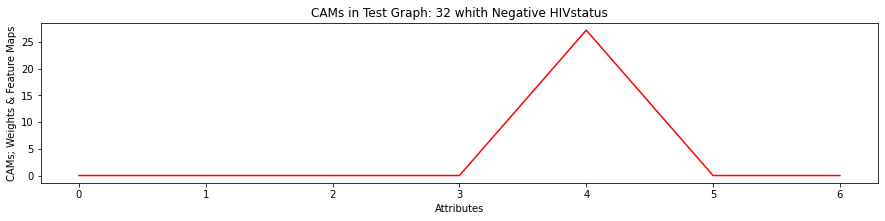

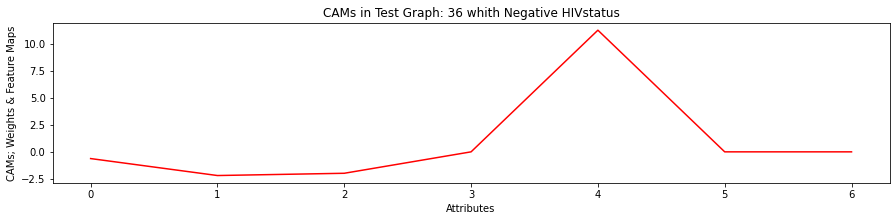

In [ ]:
HIV_status = "Positive HIV"
for i in range(len(HIV_POS)):
  visualize_CAMs(HIV_POS[i], HIV_POS_index[i], HIV_status)

HIV_status = "Negative HIV"
for i in range(len(HIV_NEG)):
  visualize_CAMs(HIV_NEG[i], HIV_NEG_index[i], HIV_status)

In [ ]:
#print(Weights_of_the_Winner_Node[0])
#print('***********************************')
#print(Feature_Maps_of_the_Last_Conv[0][0])
#print('===================================')
#print(CAMs_of_Nodes_for_each_graph[0][0])

In [ ]:
#print(np.shape(FeatureMaps_of_the_Last_Conv))
#for i in range(len(FeatureMaps_of_the_Last_Conv[0])):
#  print(FeatureMaps_of_the_Last_Conv[0][i])

In [ ]:
#CAM_model_GCN.eval()
#x = []
#for batched_data in test_dataset:
#    Last_Conv, GAP, cam_preds = CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
#    x.append(Last_Conv)

In [ ]:
#print('CAM_Test_Last_Conv')
#print(CAM_Test_Last_Conv)
#print("=========================================================================")
#print(len(x))

#summ = 0
#for i in range(len(x)):
#  print(len(x[i]), test_dataset[i].num_nodes)
#  summ=summ+len(x[i])
#print(summ)

# **Upto the last Conv layer**

# **Gradients of CAM**


In [ ]:
'''def accumulate_gradients(model_for_you):
  before_CAM = []
  after_CAM = []

  for name, param in model_for_you.named_parameters():

    if name == "conv1.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv1.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "conv2.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv2.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "conv3.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv3.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "lin.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())


  return before_CAM, after_CAM'''

In [ ]:
#holder_of_old_gradients, holder_of_new_gradients = accumulate_gradients(CAM_model_GCN)

In [ ]:
#print(len(holder_of_new_gradients))

8
